# Stable Diffusion Icons: Fine-Tune Training of Stable Diffusion

Based on: [Pokemon FineTuning from Lambda Labs ML](https://github.com/LambdaLabsML/examples/blob/main/stable-diffusion-finetuning/pokemon_finetune.ipynb)



In [23]:
# Note: Run this cell, then you'll need to click the "Restart" button that pops up
# this is a result of the installation, and I don't think there's any way around this.

#!git clone https://github.com/devonbrackbill/stable-diffusion.git
#%cd stable-diffusion
#!pip install --upgrade pip
!pip install -r requirements.txt

!pip install --upgrade keras # on lambda stack we need to upgrade keras
!pip uninstall -y torchtext # on colab we need to remove torchtext

!pip install huggingface_hub

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu113
Obtaining taming-transformers from git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers (from -r requirements.txt (line 29))
  Updating ./src/taming-transformers clone (to revision master)
  Running command git fetch -q --tags
  Running command git reset --hard -q 24268930bf1dce879235a7fddd0b2355b84d7ea6
  Preparing metadata (setup.py) ... done
Obtaining clip from git+https://github.com/openai/CLIP.git@main#egg=clip (from -r requirements.txt (line 30))
  Updating ./src/clip clone (to revision main)
  Running command git fetch -q --tags
  Running command git reset --hard -q d50d76daa670286dd6cacf3bcd80b5e4823fc8e1
  Preparing metadata (setup.py) ... done
Obtaining file:///home/ubuntu/stable-diffusion (from -r requirements.txt (line 31))
  Preparing metadata (setup.py) ... done
  Attempting unins

# 1. Download Image Icons from FontAwesome

In [24]:
!pip install cairosvg pandas

Defaulting to user installation because normal site-packages is not writeable
--- Logging error ---
Traceback (most recent call last):
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 177, in emit
    self.console.print(renderable, overflow="ignore", crop=False, style=style)
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1673, in print
    extend(render(renderable, render_options))
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1305, in render
    for render_output in iter_render:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_internal/utils/logging.py", line 134, in __rich_console__
    for line in lines:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/segment.py", line 249, in split_lines
    for segment in segments:
  File "/home/ubuntu/.local/lib/python3.8/site-packages/pip/_vendor/rich/console.py", line 1283, in

In [25]:
import os
import subprocess
import zipfile
import cairosvg
import pandas as pd
import json
import cv2
from PIL import Image

In [26]:
try:
    os.mkdir('res')
    print('created /res directory')
except OSError:
    print("res/ already exists")

res/ already exists


In [27]:
# fetch Fontawesome
if len([file for file in os.listdir('res/') if 'fontawesome' in file]) == 0:
    subprocess.call(
        ["wget", 
        "https://use.fontawesome.com/releases/v6.2.0/fontawesome-free-6.2.0-web.zip", 
        "--directory-prefix=res"])
else:
    print("fontawesome is already downloaded: {}".format([file for file in os.listdir('res/') if 'fontawesome' in file]))

fontawesome is already downloaded: ['fontawesome-free-6.2.0-web.zip', 'fontawesome-free-6.2.0-web', 'fontawesome-png']


In [28]:
# unzip
fontawesome_dir = ['res/' + file for file in os.listdir('res/') if 'fontawesome' in file and '.zip' in file][0]

with zipfile.ZipFile(fontawesome_dir,"r") as zip_ref:
    zip_ref.extractall("res")

fontawesome_dir = ['res/' + file for file in os.listdir('res/') if 'fontawesome' in file and 'zip' not in file][0]

print('FontAwesome files saved in: {}'.format(fontawesome_dir))


FontAwesome files saved in: res/fontawesome-free-6.2.0-web


In [29]:
# read svg file -> png data
WIDTH = 512
HEIGHT = 512
png_dir = 'res/fontawesome-png'

try:
    os.mkdir(png_dir)
except OSError:
    print("{} already exists".format(png_dir))

files = sorted(os.listdir(os.path.join(fontawesome_dir, 'svgs', 'solid')))

filenames = [file.split('.svg')[0] for file in files]
textdescrip = [file.replace('-', ' ') for file in filenames]
filenames_png = [file + '.png' for file in filenames]

for file, filename in zip(files, filenames):
    cairosvg.svg2png(url=os.path.join(fontawesome_dir, 'svgs', 'solid', file), 
                     output_width=WIDTH, 
                     output_height=HEIGHT,
                     write_to=os.path.join(png_dir, filename + '.png'))
    # read in the image
    img = cv2.imread(os.path.join(png_dir, filename + '.png'), cv2.IMREAD_UNCHANGED)

    if len(img.shape) and img.shape[2] == 4:

        # change black -> white and white -> black
        img[:,:,0] = 255-img[:,:,3]
        img[:,:,1] = 255-img[:,:,3]
        img[:,:,2] = 255-img[:,:,3]
        # remove 4th color channel (4th is alpha channel)
        img = img[:, :, :3]

        cv2.imwrite(os.path.join(png_dir, filename + '.png'), img)
    else:
        print("Image does not have 4 channels; deleting it: {}".format(os.path.join(png_dir, filename + '.png')))
        os.unlink(os.path.join(png_dir, filename + '.png'))

res/fontawesome-png already exists
Image does not have 4 channels; deleting it: res/fontawesome-png/square-full.png


In [30]:
filenames_df = pd.DataFrame({#'file_name' : files,
                             'file_name': filenames_png,
                             'text': textdescrip})
filenames_df.tail()

,file_name,text
1383,xmarks-lines.png,xmarks lines
1384,y.png,y
1385,yen-sign.png,yen sign
1386,yin-yang.png,yin yang
1387,z.png,z


In [98]:
metadata = []
for idx, row in filenames_df.iterrows():
    metadata.append({'file_name': row['file_name'],
                   'txt': "black and white SVG icon of {}, fontawesome, nounproject".format(row['text'])})

In [100]:
metadata_list_of_strs = []
for item in metadata:
    metadata_list_of_strs.append(json.dumps(item))

In [101]:
# metadata_string = '\n'.join(metadata_list_of_strs)

In [102]:
with open(os.path.join(png_dir, 'metadata.txt'), 'w') as f:
    # f.writelines(metadata_list_of_strs)
    for line in metadata_list_of_strs:
        f.write(line + '\n')

# convert to .jsonl file
os.rename(os.path.join(png_dir, 'metadata.txt'), os.path.join(png_dir, 'metadata.jsonl'))

In [103]:
filenames_df[filenames_df['file_name'].str.contains('train')]

,file_name,text
1246,train-subway.png,train subway
1247,train-tram.png,train tram
1248,train.png,train


In [104]:
[file for file in os.listdir(png_dir) if 'json' in file]

['metadata.jsonl']

# 2. Convert to Right format for Stable Diffusion Pytorch (HuggingFace DataSet object)

In [105]:
# Check the dataset
from datasets import load_dataset
# ds = load_dataset("lambdalabs/pokemon-blip-captions", split="train")
# sample = ds[0]
# display(sample["image"].resize((256, 256)))
# print(sample["text"])

In [106]:
# ds = load_dataset("imagefolder", 
#                   data_files={"train": "res/fontawesome-png/**", 
#                               #"test": "path/to/test/**", 
#                               #"valid": "path/to/valid/**"
#                               })
ds = load_dataset("imagefolder", 
                  data_dir="res/fontawesome-png/", split="train")

Using custom data configuration default-ccefb9efa7eaaa7c


Extracting data files: 0it [00:00, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset imagefolder downloaded and prepared to /home/ubuntu/.cache/huggingface/datasets/imagefolder/default-ccefb9efa7eaaa7c/0.0.0/0fc50c79b681877cc46b23245a6ef5333d036f48db40d53765a68034bc48faff. Subsequent calls will reuse this data.


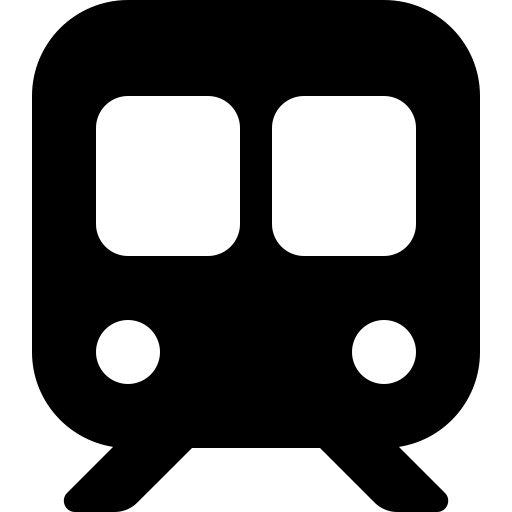

black and white SVG icon of train subway, fontawesome, nounproject


In [108]:
sample = ds[0]
display(sample["image"])
print(sample["txt"])

In [40]:
sample

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=512x512>,
 'text': 'train subway'}

# 3. Fine Tune Stable Diffusion

copied from: https://github.com/LambdaLabsML/examples/blob/main/stable-diffusion-finetuning/pokemon_finetune.ipynb

In [109]:
!nvidia-smi

Wed Oct 26 12:52:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  On   | 00000000:06:00.0 Off |                    0 |
| N/A   39C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [42]:
# from google.colab import output
# output.enable_custom_widget_manager()

In [43]:
#!pip install huggingface_hub
from huggingface_hub import notebook_login
notebook_login()

In [44]:
from huggingface_hub import hf_hub_download
ckpt_path = hf_hub_download(repo_id="CompVis/stable-diffusion-v-1-4-original", 
                            filename="sd-v1-4-full-ema.ckpt", 
                            use_auth_token=True)

Downloading:   0%|          | 0.00/7.70G [00:00<?, ?B/s]

In [62]:
# 2xA6000:

# BATCH_SIZE = 4
BATCH_SIZE = 1
N_GPUS = 1
ACCUMULATE_BATCHES = 1

if N_GPUS > 1:
    gpu_list = ",".join((str(x) for x in range(N_GPUS))) + ","
else:
    gpu_list = "0"
print(f"Using GPUs: {gpu_list}")

Using GPUs: 0


In [46]:
!pwd

/home/ubuntu/stable-diffusion


In [47]:
ckpt_path

'/home/ubuntu/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt'

In [48]:
! ls /root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt

ls: cannot access '/root/.cache/huggingface/hub/models--CompVis--stable-diffusion-v-1-4-original/snapshots/0834a76f88354683d3f7ef271cadd28f4757a8cc/sd-v1-4-full-ema.ckpt': Permission denied


Note:

Here, I needed to add a new helper function in `stable-diffusion/ldm/data/simple` called `hf_dataset_from_local()` with the following code:

```
def hf_dataset_from_local(
    name,
    data_dir,
    image_transforms=[],
    image_column="image",
    text_column="text",
    split='train',
    image_key='image',
    caption_key='text',
    ):
    """Make huggingface dataset with appropriate list of transforms applied
    """
    ds = load_dataset(name, data_dir=data_dir, split=split)
    image_transforms = [instantiate_from_config(tt) for tt in image_transforms]
    image_transforms.extend([transforms.ToTensor(),
                                transforms.Lambda(lambda x: rearrange(x * 2. - 1., 'c h w -> h w c'))])
    tform = transforms.Compose(image_transforms)

    assert image_column in ds.column_names, f"Didn't find column {image_column} in {ds.column_names}"
    assert text_column in ds.column_names, f"Didn't find column {text_column} in {ds.column_names}"

    def pre_process(examples):
        processed = {}
        processed[image_key] = [tform(im) for im in examples[image_column]]
        processed[caption_key] = examples[text_column]
        return processed

    ds.set_transform(pre_process)
    return ds
```

In [115]:
yaml = \
"""model:
  base_learning_rate: 1.0e-03  # increased learning rate from 1.0e-04
  target: ldm.models.diffusion.ddpm.LatentDiffusion
  params:
    linear_start: 0.00085
    linear_end: 0.0120
    num_timesteps_cond: 1
    log_every_t: 200
    timesteps: 1000  # increased from 1000
    first_stage_key: "image"
    cond_stage_key: "txt"
    image_size: 64
    channels: 4
    cond_stage_trainable: false   # Note: different from the one we trained before
    conditioning_key: crossattn
    scale_factor: 0.18215

    scheduler_config: # 10000 warmup steps
      target: ldm.lr_scheduler.LambdaLinearScheduler
      params:
        warm_up_steps: [ 1 ] # NOTE for resuming. use 10000 if starting from scratch
        cycle_lengths: [ 10000000000000 ] # incredibly large number to prevent corner cases
        f_start: [ 1.e-6 ]
        f_max: [ 1. ]
        f_min: [ 1. ]

    unet_config:
      target: ldm.modules.diffusionmodules.openaimodel.UNetModel
      params:
        image_size: 32 # unused
        in_channels: 4
        out_channels: 4
        model_channels: 320
        attention_resolutions: [ 4, 2, 1 ]
        num_res_blocks: 2
        channel_mult: [ 1, 2, 4, 4 ]
        num_heads: 8
        use_spatial_transformer: True
        transformer_depth: 1
        context_dim: 768
        use_checkpoint: True
        legacy: False

    first_stage_config:
      target: ldm.models.autoencoder.AutoencoderKL
      ckpt_path: "models/first_stage_models/kl-f8/model.ckpt"
      params:
        embed_dim: 4
        monitor: val/rec_loss
        ddconfig:
          double_z: true
          z_channels: 4
          resolution: 256
          in_channels: 3
          out_ch: 3
          ch: 128
          ch_mult:
          - 1
          - 2
          - 4
          - 4
          num_res_blocks: 2
          attn_resolutions: []
          dropout: 0.0
        lossconfig:
          target: torch.nn.Identity

    cond_stage_config:
      target: ldm.modules.encoders.modules.FrozenCLIPEmbedder


data:
  target: main.DataModuleFromConfig
  params:
    batch_size: 4
    num_workers: 4
    num_val_workers: 0 # Avoid a weird val dataloader issue
    train:
      target: ldm.data.simple.hf_dataset_from_local
      params:
        name: imagefolder
        data_dir: res/fontawesome-png
        image_transforms:
        - target: torchvision.transforms.Resize
          params:
            size: 512
            interpolation: 3
        - target: torchvision.transforms.RandomCrop
          params:
            size: 512
        # - target: torchvision.transforms.RandomHorizontalFlip
        text_column: txt
        image_column: image
        caption_key: txt
    validation:
      target: ldm.data.simple.TextOnly
      params:
        captions:
        - "{prefix}radar{postfix}"
        - "{prefix}bunny rabbit{postfix}"
        - "{prefix}Yoda{postfix}"
        - "{prefix}coffee{postfix}"
        - "{prefix}palm tree{postfix}"
        - "{prefix}evergreen tree{postfix}"
        - "{prefix}toucan{postfix}"
        - "{prefix}thumbs up{postfix}"
        - "{prefix}butterfly{postfix}"
        output_size: 512
        n_gpus: 1 # small hack to sure we see all our samples; # I changed this to 1


lightning:
  find_unused_parameters: False

  modelcheckpoint:
    params:
      every_n_train_steps: 500
      save_top_k: -1
      monitor: null

  callbacks:
    image_logger:
      target: main.ImageLogger
      params:
        batch_frequency: 2000
        max_images: 10
        increase_log_steps: False
        log_first_step: True
        log_all_val: True
        log_images_kwargs:
          use_ema_scope: True
          inpaint: False
          plot_progressive_rows: False
          plot_diffusion_rows: False
          N: 4
          unconditional_guidance_scale: 3.0
          unconditional_guidance_label: [""]

  trainer:
    benchmark: True
    num_sanity_val_steps: 0
    accumulate_grad_batches: 1
""".format(**{'prefix': 'black and white SVG icon of ',
              'postfix': ', fontawesome, nounproject'})

with open('configs/stable-diffusion/retrain-icons.yaml', 'w') as f:
  f.write(yaml)

In [59]:
gpu_list

'0'

In [60]:
! ls

LICENSE			    examples		       notebook_helpers.py
README.md		    im-examples		       notebooks
StableDiffusionIcons.ipynb  latent_diffusion.egg-info  requirements.txt
__pycache__		    ldm			       res
assets			    logs		       scripts
configs			    main.py		       setup.py
data			    models		       src


In [52]:
# # Run training (original command)
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --gpus "$gpu_list" \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
#     data.params.validation.params.n_gpus="$NUM_GPUS" \
# )

In [53]:
# img_pil = Image.open('res/fontawesome-png/anchor-lock.png')
# print('Pillow: ', img_pil.mode, img_pil.size)

# img = cv2.imread('res/fontawesome-png/anchor-lock.png', cv2.IMREAD_UNCHANGED)
# print('OpenCV: ', img.shape)

# img = cv2.imread('res/fontawesome-png/anchor-lock.png', cv2.IMREAD_UNCHANGED)
# print('OpenCV: ', img.shape)

In [ ]:
# Run training
!(python main.py \
    -t \
    --base configs/stable-diffusion/retrain-icons.yaml \
    --auto_select_gpus \
    --gpus=1 \
    --scale_lr False \
    --num_nodes 1 \
    --check_val_every_n_epoch 10 \
    --finetune_from "$ckpt_path" \
    data.params.batch_size="$BATCH_SIZE" \
    lightning.trainer.accumulate_grad_batches=1 \
    data.params.validation.params.n_gpus=1 \
)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Global seed set to 23
Running on GPUs 1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.4.self_attn.v_proj.bias', 'vision_model.encoder.layers.8.mlp.fc1.bias', 'vision_model.encoder.layers.11.mlp.fc1.weight', 'vision_model.encoder.layers.13.layer_norm1.weight', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.13.mlp.fc1.weight', 'v

In [51]:
# # Run training
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --gpus=1 \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches=1 \
#     data.params.validation.params.n_gpus=1 \
# )

Global seed set to 23
Running on GPUs 1
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.3.mlp.fc1.weight', 'vision_model.encoder.layers.7.self_attn.v_proj.bias', 'vision_model.encoder.layers.23.layer_norm1.weight', 'vision_model.encoder.layers.10.self_attn.out_proj.bias', 'vision_model.encoder.layers.1.layer_norm2.bias', 'vision_model.pre_layrnorm.bias', 'vision_model.encoder.layers.22.layer_norm1.weight', 'vision_model.encoder.layers.16.mlp.fc2.bias', 'vision_model.encoder.layers.11.mlp.fc1.bias', 'vision_model.encoder.layers.18.mlp.fc1.bias', 'vision_model.encoder.layers.23.self_attn.k_proj.weight', 'vision_model.p

In [45]:
# # Run training
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --auto_select_gpus \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches="$ACCUMULATE_BATCHES" \
#     data.params.validation.params.n_gpus="$NUM_GPUS" \
# )

Global seed set to 23
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.17.layer_norm1.bias', 'vision_model.encoder.layers.1.layer_norm1.weight', 'vision_model.encoder.layers.18.self_attn.k_proj.bias', 'vision_model.encoder.layers.7.mlp.fc2.bias', 'vision_model.encoder.layers.6.layer_norm1.weight', 'vision_model.encoder.layers.6.self_attn.k_proj.bias', 'vision_model.encoder.layers.20.mlp.fc2.weight', 'vision_model.encoder.layers.23.self_attn.v_proj.weight', 'vision_model.encoder.layers.1.self_attn.out_proj.bias', 'vision_model.encoder.layers.14.mlp.fc1.bias', 'vision_model.encoder.layers.4.mlp.fc1.weight', 'vision_mode

In [97]:
# Run training
# !(python main.py \
#     -t \
#     --base configs/stable-diffusion/retrain-icons.yaml \
#     --auto_select_gpus \
#     --gpus=1 \
#     --scale_lr False \
#     --num_nodes 1 \
#     --check_val_every_n_epoch 10 \
#     --finetune_from "$ckpt_path" \
#     data.params.batch_size="$BATCH_SIZE" \
#     lightning.trainer.accumulate_grad_batches=1 \
#     data.params.validation.params.n_gpus=1 \
# )

# Run inference
!(python scripts/txt2img.py \
    --prompt 'black and white SVG icon of donald trump, fontawesome, thenounproject' \
    --outdir 'outputs/generated_icons' \
    --H 512 --W 512 \
    --n_samples 10 \
    --config 'configs/stable-diffusion/retrain-icons.yaml' \
    --ckpt 'logs/2022-10-26T04-04-20_retrain-icons/checkpoints/epoch=000666.ckpt' \
)

/home/ubuntu/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
Global seed set to 42
Loading model from logs/2022-10-26T04-04-20_retrain-icons/checkpoints/epoch=000666.ckpt
Global Step: 2000
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels
Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.10.mlp.fc1.bias', 'vision_model.encoder.layers.22.mlp.fc1.weight', 'vision_model.encoder.layers.22.layer_norm1.bias', 'vision_model.encoder.layers.17.self_attn.k_proj.bias', 'vision_model.e

In [86]:
!ls logs/2022-10-26T04-04-20_retrain-icons/checkpoints

'epoch=000666.ckpt'   last.ckpt
